In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.style.use('ggplot')

# limiting courses

It's important to limit the data set to only courses for physics majors so that we can more accurately compare physics majors to non-majors and physics majors that end up getting different degrees. While MSU offers a BS and BA in physics and astronomy and astrophysics the core introductory courses (i.e. 100 and 200 level) are the same. The 100 and 200 level courses that are required are as follows:

| level | physics | Math |
|---|---|---|
| 100 | PHY183, PHY184, PHY193H, PhY294H, PHY191, PHY192 | MTH132, MTH133,   |
| 200 | PHY215 | MTH234, MTH235 |


Additionally students are required to have four semester credits equivalent to one of the following courses: MTH110, MTH116, MTH124, MTH132. These are not accounted for in this data set. We also have removed students who have not graduated yet.

**Sources:**

1. http://www.pa.msu.edu/undergrad/BS_Physics.pdf
2. http://www.pa.msu.edu/undergrad/BS_Astrophysics.pdf

## SQL Query for raw data

    /****** Script for SelectTopNRows command from SSMS  ******/
    DECLARE @z_score TABLE (id varchar(50), course_id varchar(6), grade_code FLOAT, z_score FLOAT, class_type varchar(3))

    INSERT INTO @z_score
    SELECT [PlaceholderID]
          ,LEFT([course_id],6) AS course_id
          ,[grade_code]
          ,[z_score]
          ,[class_type]
      FROM [MSU_ProjectPathways].[dbo].[z_scores_14_1_2016]

    SELECT d.PlaceholderID
    , d.[Graduating Major Category]
    , d.Ethnicity
    , d.gndr_flag
    , d.[Physics major at one time]
    , z.class_type
    , z.course_id
    , z.grade_code
    , z.z_score
    FROM @z_score AS z
    LEFT JOIN [MSU_ProjectPathways].[dbo].demographics AS d
    ON d.PlaceholderID = z.id
    WHERE z.course_id IN ('PHY183', 'PHY184', 'PHY193H', 'PHY294H', 'PHY191', 'PHY192', 'PHY215', 'MTH132', 'MTH133', 'MTH234', 'MTH235')

In [63]:
# z_score = pd.read_clipboard()
z_score = pd.read_csv('data_12_6_2016.csv' )
z_score.columns = ['PlaceholderID', 'First Major Category', 'Graduating Major Category'
                                                   , 'Ethnicity', 'gndr_flag', 'Physics major at one time'
                                                     , 'class_type', 'course_id', 'grade_code', 'z_score']

In [64]:
z_score.head()

,PlaceholderID,First Major Category,Graduating Major Category,Ethnicity,gndr_flag,Physics major at one time,class_type,course_id,grade_code,z_score
0,9739CD0E-040A-4B92-8F34-3F2E2661CEC7,Physics,Has Not Graduated,Asian (non-Hispanic),M,Y,MTH,MTH133,3.5,0.864641
1,9739CD0E-040A-4B92-8F34-3F2E2661CEC7,Physics,Has Not Graduated,Asian (non-Hispanic),M,Y,MTH,MTH235,0.0,-2.424311
2,97469CA0-54F0-4106-A645-D0C58E5B4101,Other STEM,Non STEM,Not Reported,M,N,MTH,MTH234,1.0,-1.217061
3,974A3C85-788A-471B-AB80-EF79FC880F4E,Engineering,Engineering,White (non-Hispanic),M,N,MTH,MTH235,4.0,1.054445
4,974D9233-24ED-4C7B-B0A0-2073792BEEFF,Non STEM,Has Not Graduated,White (non-Hispanic),F,N,MTH,MTH133,3.0,0.212709


In [108]:
z_score.PlaceholderID.nunique()+10929+748

27549

In [106]:
z_score.groupby(['Graduating Major Category', 'Physics major at one time']).PlaceholderID.nunique()

Graduating Major Category  Physics major at one time
Engineering                N                            4047
                           Y                             374
Non STEM                   N                            4913
                           Y                             134
Other STEM                 N                            5833
                           Y                             202
Physics                    Y                             369
Name: PlaceholderID, dtype: int64

In [65]:
z_score.PlaceholderID.unique().shape

(27549,)

In [66]:
z_score = z_score[z_score['Graduating Major Category'] != 'Has Not Graduated']

In [67]:
physics_math_sem = z_score.groupby(['Physics major at one time','Graduating Major Category','class_type']).z_score.sem()


In [68]:
physics_math = z_score.groupby(['Physics major at one time','Graduating Major Category','class_type']).mean()
physics_math = physics_math.reset_index()

In [69]:
physics_math_count = z_score.groupby(['Physics major at one time','Graduating Major Category','class_type']).z_score.count()
physics_math_count = physics_math_count.reset_index()

In [70]:
physics_math = physics_math.join(physics_math_count, lsuffix='left')[['Physics major at one time','Graduating Major Category'
                                                                     ,'class_type', 'z_scoreleft', 'z_score']]

In [71]:
physics_math.columns = ['physics_major', 'major_category', 'class_type', 'z_score','count']

In [72]:
physics_math = physics_math.join(physics_math_sem.reset_index().z_score, lsuffix='left')
physics_math.columns = ['physics_major', 'major_category', 'class_type', 'z_score', 'cnt', 'error']

In [73]:
physics = physics_math[physics_math.class_type == 'PHY']
math = physics_math[physics_math.class_type == 'MTH']
math.index = physics.index

In [74]:
physics['color'] = ['gray','gray','gray','crimson','crimson','crimson','crimson']

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [75]:
physics

,physics_major,major_category,class_type,z_score,cnt,error,color
1,N,Engineering,PHY,0.289325,6643,0.009220,gray
3,N,Non STEM,PHY,-0.494015,1273,0.029454,gray
5,N,Other STEM,PHY,0.082566,5292,0.012522,gray
7,Y,Engineering,PHY,-0.189934,684,0.030135,crimson
9,Y,Non STEM,PHY,-0.669159,221,0.072372,crimson
11,Y,Other STEM,PHY,-0.046429,418,0.049031,crimson
13,Y,Physics,PHY,0.236732,1262,0.023355,crimson


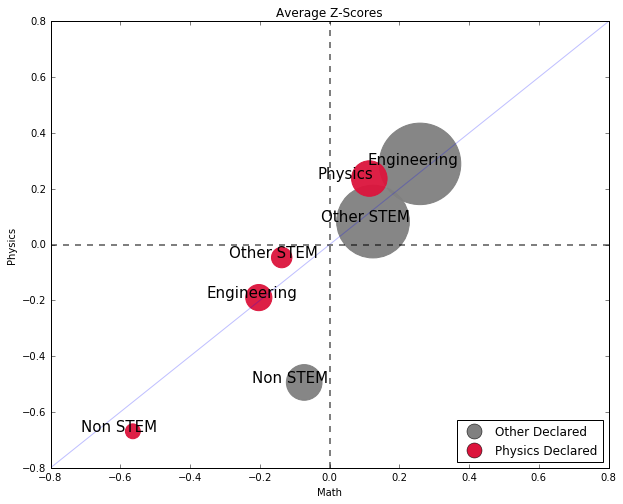

In [76]:
fig, ax = plt.subplots(1, figsize=(10,8))

#ax.scatter(x=math.z_score, y=physics.z_score, s=math.cnt, alpha=0.5, color='red')

ax.plot([],[], marker='o', color='gray', markersize=15, linestyle='', label='Other Declared')
ax.plot([],[], marker='o', color='crimson', markersize=15, linestyle='', label='Physics Declared')
ax.legend(numpoints=1, loc='lower right')


ax.plot([-0.8,0.8], [-0.8,0.8], alpha=0.25)

ax.plot([0,0], [-0.8, 0.8], linestyle='--', color='black', alpha=0.5, linewidth=2)
ax.plot([-0.8, 0.8], [0,0], linestyle='--', color='black', alpha=0.5, linewidth=2)

ax.scatter(x=math.z_score, y=physics.z_score, s=physics.cnt, color=physics.color, alpha=0.95)

#ax.errorbar(x=math.z_score, y=physics.z_score, xerr=math.error, yerr=physics.error)

for s,x,y in zip(physics.major_category, math.z_score, physics.z_score):
    ax.text(s=s,x=x-0.15,y=y, fontsize=15)

    

ax.set_ylim(-0.8, 0.8)
ax.set_xlim(-0.8, 0.8)

ax.set_ylabel('Physics')
ax.set_xlabel('Math')
ax.set_title('Average Z-Scores')


Student Physics and Math z scores. Scores are averaged per group but are not matched. The size of the marker indicates the size of the population and scales linearly. Physics students who receive BS or BA degrees in physics/astronomy are above average in their introductory course performance in comparison to students who move to different programs before graduating. They are comparable to STEM (engineering and other stem) students who take the prequisite introductory courses for the major. This plot with error bars representing the standard error of the mean can be seen below.

In [77]:
physics_math = math.join(physics, lsuffix=' math', rsuffix=' physics')

In [78]:
physics_math

,physics_major math,major_category math,class_type math,z_score math,cnt math,error math,physics_major physics,major_category physics,class_type physics,z_score physics,cnt physics,error physics,color
1,N,Engineering,MTH,0.259347,12491,0.007500,N,Engineering,PHY,0.289325,6643,0.009220,gray
3,N,Non STEM,MTH,-0.072762,8095,0.011078,N,Non STEM,PHY,-0.494015,1273,0.029454,gray
5,N,Other STEM,MTH,0.124545,10078,0.009192,N,Other STEM,PHY,0.082566,5292,0.012522,gray
7,Y,Engineering,MTH,-0.202908,1396,0.023557,Y,Engineering,PHY,-0.189934,684,0.030135,crimson
9,Y,Non STEM,MTH,-0.564118,382,0.049475,Y,Non STEM,PHY,-0.669159,221,0.072372,crimson
11,Y,Other STEM,MTH,-0.137269,555,0.039450,Y,Other STEM,PHY,-0.046429,418,0.049031,crimson
13,Y,Physics,MTH,0.113995,919,0.031818,Y,Physics,PHY,0.236732,1262,0.023355,crimson


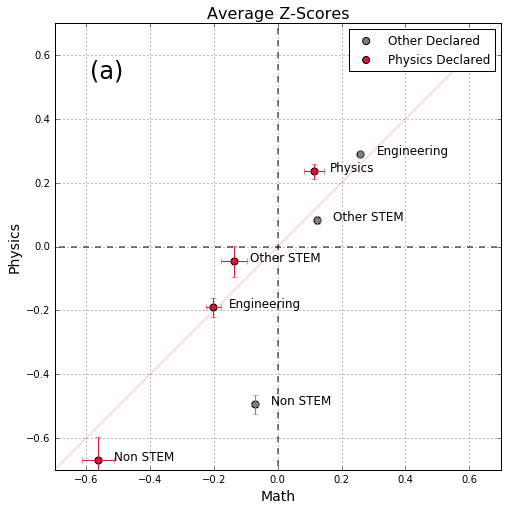

In [79]:
fig, ax = plt.subplots(1, figsize=(8,8))

msize = 50

physics_math[physics_math['physics_major math']=='N'].plot(kind='scatter', x='z_score math', y='z_score physics'
                                                           , xerr='error math', yerr='error physics', ax=ax, s=msize
                                                          , color='gray', label='Other Declared')
physics_math[physics_math['physics_major math']=='Y'].plot(kind='scatter', x='z_score math', y='z_score physics'
                                                           , xerr='error math', yerr='error physics', ax=ax, s=msize
                                                          , color='crimson', label='Physics Declared')


ax.plot([-0.8,0.8], [-0.8,0.8], alpha=0.25)

ax.plot([0,0], [-0.8, 0.8], linestyle='--', color='black', alpha=0.5, linewidth=2)
ax.plot([-0.8, 0.8], [0,0], linestyle='--', color='black', alpha=0.5, linewidth=2)

#ax.errorbar(x=math.z_score, y=physics.z_score, xerr=math.error, yerr=physics.error)

for s,x,y in zip(physics.major_category, math.z_score, physics.z_score):
    ax.text(s=s,x=x+0.05,y=y, fontsize=12)

    

ax.set_ylim(-0.7, 0.7)
ax.set_xlim(-0.7, 0.7)

ax.set_ylabel('Physics', fontsize=14)
ax.set_xlabel('Math', fontsize=14)
ax.set_title('Average Z-Scores', fontsize=16)

ax.legend(scatterpoints=1)
ax.grid(True)
ax.text(x=-0.59, y=0.53, s='(a)', fontsize=24)
fig.savefig('z_scores.pdf', bbox_inches='tight')

Same plot as above but error bars represent standard error of the mean for their respective axes. There is no direct indication of population size (of course SEM is a reasonable approximation given how it's calculated :-P )

In [80]:
physmajors_gb = z_score[z_score['Physics major at one time']=='Y'].groupby(['First Major Category', 'class_type'])

In [81]:
physmajors_avg = physmajors_gb.mean().reset_index()

In [82]:
physmajors_avg

,First Major Category,class_type,grade_code,z_score
0,Engineering,MTH,1.941007,-0.371859
1,Engineering,PHY,2.678205,-0.353085
2,Non STEM,MTH,2.422397,-0.016008
3,Non STEM,PHY,3.076327,0.114111
4,Other STEM,MTH,2.517241,-0.022046
5,Other STEM,PHY,3.073359,0.084151
6,Physics,MTH,2.540452,0.057620
7,Physics,PHY,3.150823,0.186090


In [83]:
z_score[z_score['Physics major at one time']=='Y'].groupby('Graduating Major Category')['PlaceholderID'].unique()

Graduating Major Category
Engineering    [978968BC-95A6-467D-8078-36F45D7D61EE, 980EB1A...
Non STEM       [982072E3-5814-4391-8DE1-1D040E9364DA, 9D5E9FC...
Other STEM     [9B3C4A04-0D14-4AFB-981A-D9D1C7C3AB04, 960E314...
Physics        [9A0C1927-4A3D-45FA-84FD-3D1A6BA7238C, 9ABBA31...
Name: PlaceholderID, dtype: object

In [84]:
for x in z_score[z_score['Physics major at one time']=='Y'].groupby('Graduating Major Category')['PlaceholderID'].unique():
    print(len(x))

374
134
202
369


In [85]:
z_score[z_score['Graduating Major Category']=='Physics'].groupby('First Major Category')['PlaceholderID'].unique()

First Major Category
Engineering    [9A0C1927-4A3D-45FA-84FD-3D1A6BA7238C, 8B6607B...
Non STEM       [9ABBA315-1126-4341-94B2-3444F04AD596, 8F09CF8...
Other STEM     [9B4E81F9-286C-4344-948F-322C6FE1E610, 9CCCAC2...
Physics        [9BC56BCC-0C6A-44FB-B7C7-36BB699B8DED, 9DDB14F...
Name: PlaceholderID, dtype: object

In [86]:
[len(x) for x in z_score[z_score['Graduating Major Category']=='Physics'].groupby('First Major Category')['PlaceholderID'].unique()]

[44, 73, 28, 224]

In [87]:
physmajors_sem = physmajors_gb.sem().reset_index()[['First Major Category', 'class_type', 'z_score']]

In [88]:
physmajors_sem

,First Major Category,class_type,z_score
0,Engineering,MTH,0.023644
1,Engineering,PHY,0.031027
2,Non STEM,MTH,0.042704
3,Non STEM,PHY,0.041191
4,Other STEM,MTH,0.049578
5,Other STEM,PHY,0.052591
6,Physics,MTH,0.030031
7,Physics,PHY,0.027476


In [89]:
physmajors_avg[physmajors_avg.class_type=='MTH']

,First Major Category,class_type,grade_code,z_score
0,Engineering,MTH,1.941007,-0.371859
2,Non STEM,MTH,2.422397,-0.016008
4,Other STEM,MTH,2.517241,-0.022046
6,Physics,MTH,2.540452,0.057620


In [90]:
physmajors_avg[physmajors_avg.class_type=='PHY']

,First Major Category,class_type,grade_code,z_score
1,Engineering,PHY,2.678205,-0.353085
3,Non STEM,PHY,3.076327,0.114111
5,Other STEM,PHY,3.073359,0.084151
7,Physics,PHY,3.150823,0.186090


In [91]:
labels = pd.DataFrame({'category':physmajors_avg[physmajors_avg.class_type=='PHY']['First Major Category'].values
                      ,'y':physmajors_avg[physmajors_avg.class_type=='PHY']['z_score'].values
                     ,'x':physmajors_avg[physmajors_avg.class_type=='MTH']['z_score'].values
                     ,'n':[len(x) for x in z_score[z_score['Graduating Major Category']=='Physics'].groupby('First Major Category')['PlaceholderID'].unique()]})
labels

,category,n,x,y
0,Engineering,44,-0.371859,-0.353085
1,Non STEM,73,-0.016008,0.114111
2,Other STEM,28,-0.022046,0.084151
3,Physics,224,0.057620,0.186090


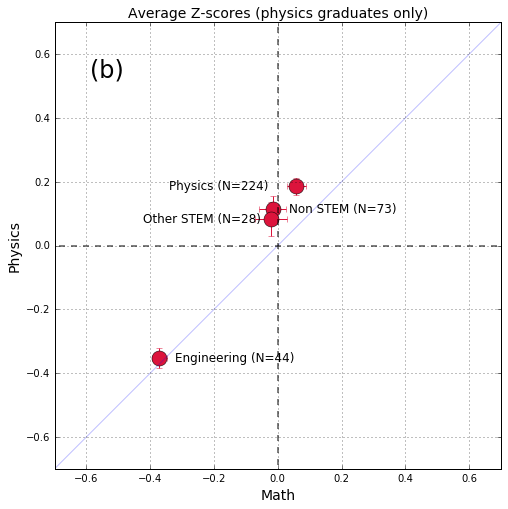

In [92]:
fig, ax = plt.subplots(1, figsize=(8,8))

ax.errorbar(physmajors_avg[physmajors_avg.class_type=='MTH'].z_score.values
        , physmajors_avg[physmajors_avg.class_type=='PHY'].z_score.values
       , linestyle='', marker='o'
       , xerr=physmajors_sem[physmajors_sem.class_type=='MTH'].z_score.values
           , yerr=physmajors_sem[physmajors_sem.class_type=='PHY'].z_score.values
           , color='crimson', markersize=15)

ax.plot([-0.8,0.8], [-0.8,0.8], alpha=0.25)

ax.plot([0,0], [-0.8, 0.8], linestyle='--', color='black', alpha=0.5, linewidth=2)
ax.plot([-0.8, 0.8], [0,0], linestyle='--', color='black', alpha=0.5, linewidth=2)

ax.set_xlim(-0.7, 0.7)
ax.set_ylim(-0.7, 0.7)
ax.grid(True)

ax.set_xlabel('Math', fontsize=14)
ax.set_ylabel('Physics', fontsize=14)
ax.set_title('Average Z-scores (physics graduates only)', fontsize=14)

for n, label in enumerate(labels.values):
    if n >= 2:
        offset = -0.4
    else:
        offset = 0.05
    ax.text(s=label[0]+' (N={n})'.format(n=label[1]), x=label[2]+offset, y=label[3]-0.01, fontsize=12)
ax.text(x=-0.59, y=0.53, s='(b)', fontsize=24)
fig.savefig('z_physics_grads_only.pdf', bbox_inches='tight')

In [93]:
course_mean = z_score.groupby(['Graduating Major Category', 'Physics major at one time', 'course_id']).z_score.mean()
course_count = z_score.groupby(['Graduating Major Category', 'Physics major at one time', 'course_id']).z_score.count()
course_stdev = z_score.groupby(['Graduating Major Category', 'Physics major at one time', 'course_id']).z_score.std()
course_sem = z_score.groupby(['Graduating Major Category', 'Physics major at one time', 'course_id']).z_score.sem()

In [94]:
course_mean = course_mean.reset_index().join(course_count.reset_index(), rsuffix=' 1')
course_mean = course_mean.reset_index().join(course_stdev.reset_index(), rsuffix=' 2')
course_mean = course_mean.reset_index().join(course_sem.reset_index(), rsuffix=' 3')

In [95]:
course_mean = course_mean[['Graduating Major Category', 'Physics major at one time', 'course_id', 'z_score'
                          ,'z_score 1', 'z_score 2', 'z_score 3']]

In [96]:
course_mean.columns =['category', 'physics_major', 'course_id', 'z_score', 'cnt', 'stdev', 'error']

In [97]:
course_y = course_mean[course_mean.physics_major=='Y']
course_n = course_mean[course_mean.physics_major=='N']

In [98]:
course_y.sort_values(by=['course_id', 'category'], inplace=True)
course_y.index = [x for x in range(len(course_y))]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [99]:
x = (data.z_score.values - data.error.values, data.z_score.values + data.error.values)

NameError: name 'data' is not defined

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(5,15))

yticks=[]

ax1.plot([],[], marker='o', linewidth=2, color='violet', label='Engineering')
ax1.plot([],[], marker='o', linewidth=2, color='red', label='Non STEM')
ax1.plot([],[], marker='o', linewidth=2, color='yellow', label='Other STEM')
ax1.plot([],[], marker='o', linewidth=2, color='green', label='Physics')
ax1.legend(numpoints=1)

for n, id in enumerate(course_ids):

    data = course_y[(course_y.course_id == id) & (course_y.category == 'Engineering')]
    ax1.plot(data.z_score, data.index, marker='o', color='violet')
    x = (data.z_score.values - data.error.values, data.z_score.values + data.error.values)
    ax1.plot(x, [data.index, data.index], linewidth=2, color='violet')    
    y1 = data.index[0] 
    
    data = course_y[(course_y.course_id == id) & (course_y.category == 'Non STEM')]
    ax1.plot(data.z_score, data.index, marker='o', color='red')
    x = (data.z_score.values - data.error.values, data.z_score.values + data.error.values)
    ax1.plot(x, [data.index, data.index], linewidth=2, color='red')
    
    data = course_y[(course_y.course_id == id) & (course_y.category == 'Other STEM')]
    ax1.plot(data.z_score, data.index, marker='o', color='yellow')
    x = (data.z_score.values - data.error.values, data.z_score.values + data.error.values)
    ax1.plot(x, [data.index, data.index], linewidth=2, color='yellow')
    
    data = course_y[(course_y.course_id == id) & (course_y.category == 'Physics')]
    ax1.plot(data.z_score, data.index, marker='o', color='green')
    x = (data.z_score.values - data.error.values, data.z_score.values + data.error.values)
    ax1.plot(x, [data.index, data.index], linewidth=2, color='green')
    y2 = data.index[0]
    
    if n % 2 == 0:
        #print(y1,y2)
        ax1.axhspan(ymin=y1-0.25, ymax=y2+0.25, facecolor='white', alpha=0.5)
        
    yticks.append(y1+1.5)
    
ax1.plot([0,0],[-5,y2+5], color='black', alpha=0.5, linewidth=3, linestyle='--')
ax1.set_yticks(yticks)
ax1.set_yticklabels(course_ids)
ax1.set_title('Physics Declared')

In [ ]:
#################################################################
################################################################
##############################################################
fig, ax1 = plt.subplots(1, figsize=(5,15))

df = course_n
# course_y.sort_values(by=['course_id', 'category'], inplace=True)
# course_y.index = [x for x in range(len(course_y))]
df.sort_values(by=['course_id', 'category'], inplace=True)
df.index = [x for x in range(len(df))]

yticks=[]

ax1.plot([],[], marker='o', linewidth=2, color='violet', label='Engineering')
ax1.plot([],[], marker='o', linewidth=2, color='red', label='Non STEM')
ax1.plot([],[], marker='o', linewidth=2, color='yellow', label='Other STEM')
#ax1.plot([],[], marker='o', linewidth=2, color='green', label='Physics')
ax1.legend(numpoints=1)

for n, id in enumerate(course_ids):

    data = df[(df.course_id == id) & (df.category == 'Engineering')]
    ax1.plot(data.z_score, data.index, marker='o', color='violet')
    x = (data.z_score.values - data.error.values, data.z_score.values + data.error.values)
    ax1.plot(x, [data.index, data.index], linewidth=2, color='violet')    
    y1 = data.index[0] 
    
    data = df[(df.course_id == id) & (df.category == 'Non STEM')]
    ax1.plot(data.z_score, data.index, marker='o', color='red')
    x = (data.z_score.values - data.error.values, data.z_score.values + data.error.values)
    ax1.plot(x, [data.index, data.index], linewidth=2, color='red')
    
    data = df[(df.course_id == id) & (df.category == 'Other STEM')]
    ax1.plot(data.z_score, data.index, marker='o', color='yellow')
    x = (data.z_score.values - data.error.values, data.z_score.values + data.error.values)
    ax1.plot(x, [data.index, data.index], linewidth=2, color='yellow')
    
#     data = df[(df.course_id == id) & (df.category == 'Physics')]
#     ax1.plot(data.z_score, data.index, marker='o', color='green')
#     x = (data.z_score.values - data.error.values, data.z_score.values + data.error.values)
#     ax1.plot(x, [data.index, data.index], linewidth=2, color='green')
    #y2 = data.index[0]
    print(data.index)
    y2=data.index[0]
    if n % 2 == 0:
        #print(y1,y2)
        ax1.axhspan(ymin=y1-0.25, ymax=y2+0.25, facecolor='white', alpha=0.5)
        
    yticks.append(y1+1.5)
    
ax1.plot([0,0],[0,y2], color='black', alpha=0.5, linewidth=3, linestyle='--')
ax1.set_yticks(yticks)
ax1.set_yticklabels(course_ids)
ax1.set_title('Other Declared')

In [ ]:
df